In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

from skimage.io import imread
from torch.utils import data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# распаковываем train и test
!unzip "/content/drive/MyDrive/grow_vision/train_22.zip" -d "/content/train_22"

#!unzip "/content/drive/MyDrive/grow_vision/train_mask.zip" -d "/content/train_mask"

In [ ]:
# распаковываем train и test
!unzip "/content/drive/MyDrive/grow_vision/test_markdown.zip" -d "/content/test_1"

!unzip "/content/drive/MyDrive/grow_vision/test_mask.zip" -d "/content/test_1"


In [ ]:
!rm -rf '/content/train_22/__MACOSX'
!rm -rf '/content/train_mask/__MACOSX'

In [ ]:
!rm -rf '/content/test_1/test_markdown/.DS_Store'

In [ ]:
import cv2
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os


In [ ]:
train_image_paths = "/content/train_22/train_22/"
train_mask_paths = "/content/train_mask/train_mask/"

train_image = [train_image_paths + name for name in sorted(os.listdir(train_image_paths))][4:]
train_mask = [train_mask_paths + name for name in sorted(os.listdir(train_mask_paths))][4:]

test_image_paths = "/content/test_1/test_markdown/"
test_mask_paths = "/content/test_1/test_mask/"

test_image = [test_image_paths + name for name in sorted(os.listdir(test_image_paths))]
test_mask = [test_mask_paths + name for name in sorted(os.listdir(test_mask_paths))]

In [ ]:
len(train_image), len(train_mask)

(296, 296)

In [ ]:
len(test_image), len(test_mask)

(100, 100)

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths

        self.transforms = Compose([
            transforms.ToTensor(),
            #transforms.RandomHorizontalFlip(p=0.5),
            transforms.Resize((384, 384)),
            
        ])



    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.target_paths[idx]))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return raw_mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = self.open_mask(index, add_dims=False)

        image = self.transforms(image)
        mask = self.transforms(mask)[0,:, :]

        return image, mask

    def __len__(self):
        return len(self.image_paths)


train_dataset = CustomDataset(train_image, train_mask, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

test_dataset = CustomDataset(test_image, test_mask, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)


In [ ]:
len(train_dataset), len(test_dataset)

(296, 100)

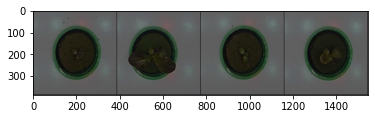

In [ ]:
def imshow(img):
    img = img / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_loader)
images, mask = dataiter.next()

imshow(torchvision.utils.make_grid(images))
plt.show()

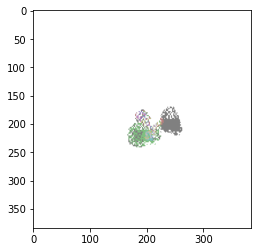

In [ ]:
imshow(torchvision.utils.make_grid(mask))
plt.show()

In [ ]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([4, 3, 384, 384]), torch.Size([4, 384, 384]))

In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [ ]:
unet = UNET(3, 2)

In [ ]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=100):
    start = time.time()
    model.cuda()
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_acc.append(epoch_acc) if phase=='train' else valid_acc.append(epoch_acc)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss, train_acc, valid_acc

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [ ]:
SEED = 192
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

train_loss, valid_loss, train_acc, valid_acc = \
train(unet, train_loader, test_loader, loss, opt, acc_metric, epochs=20)

In [ ]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [ ]:
plt.plot(train_acc)
plt.plot(valid_acc)

In [ ]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
xb, yb = next(iter(test_loader))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([4, 2, 384, 384])

In [ ]:
bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

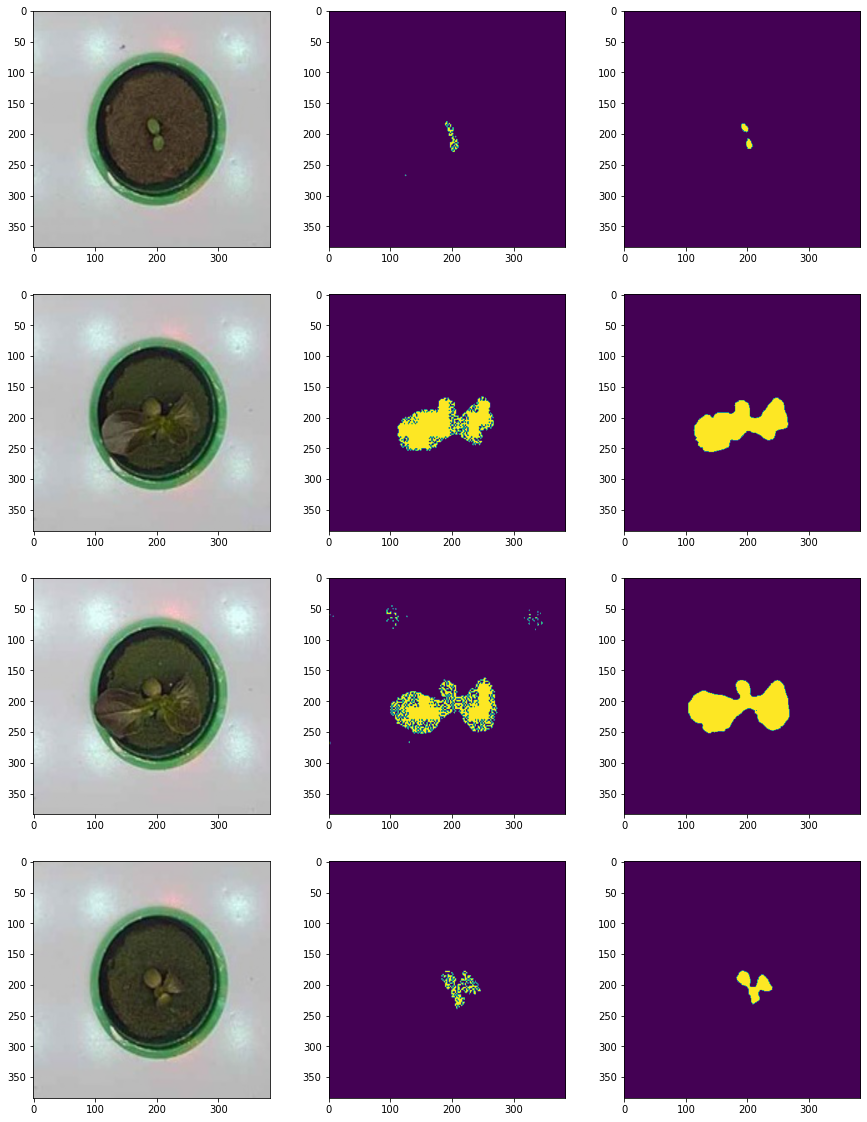

In [ ]:
bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [ ]:
torch.save(unet, '/content/drive/MyDrive/grow_vision/unet.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/grow_vision/unet.pt')
model.eval()

In [ ]:
!unzip "/content/drive/MyDrive/grow_vision/22.zip" -d "/content/22"
!rm -rf '/content/22/__MACOSX'

In [ ]:
!rm -rf '/content/22/22/.DS_Store'

In [ ]:
test_dir = "/content/test_24/test_24/"

#test_image = [test_paths + name for name in sorted(os.listdir(test_paths))]
#test_dataset = CustomDataset(test_image, test_mask, train=False)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

In [ ]:
test_paths = '/content/22/22/'
test_image = [test_paths + name for name in sorted(os.listdir(test_paths))]

test_dataset = CustomDataset(test_image, test_image, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

In [ ]:
xb, yb = next(iter(test_loader))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([4, 2, 384, 384])

In [ ]:
bs = 4
fig, ax = plt.subplots(bs, 2, figsize=(10, bs * 5))
leaf_count = []
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    mask = predb_to_mask(predb, i)
    leaf_count.append(cv2.countNonZero(mask.cpu().numpy()))
    
    ax[i,1].imshow(mask)

In [ ]:
unet.cuda()
leaf_count = []
with torch.no_grad():
    for i, (img, name) in enumerate(tqdm(test_loader)):
        img = img.cuda()
        outputs = unet(img)

        for idx in range(4):
          mask = predb_to_mask(outputs, idx)
          #print(mask)
          leaf_count.append(np.count_nonzero(mask))

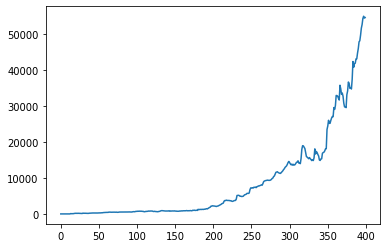

In [ ]:
plt.plot(leaf_count)

In [ ]:
leaf = pd.DataFrame(leaf_count)

In [ ]:
leaf.to_csv('/content/drive/MyDrive/grow_vision/predict_leaf_area.csv')